In [4]:
# ------------------------------------------------------------
# 1️⃣ Setup & Imports
# ------------------------------------------------------------
!pip install -q ultralytics ttach > /dev/null
import kagglehub
import os
import random
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from ultralytics import YOLO

In [6]:
import shutil
import os

# Original read-only dataset path
src_path = "/kaggle/input/tomato-leaf-diseases-dataset-for-object-detection"

# Writable path for Kaggle session
dst_path = "/kaggle/working/tomato_dataset"

# Copy entire dataset to writable folder
if not os.path.exists(dst_path):
    shutil.copytree(src_path, dst_path)

print("Dataset copied to:", dst_path)


Dataset copied to: /kaggle/working/tomato_dataset


In [7]:
# ------------------------------------------------------------
# 2️⃣ Dataset Root (Kaggle Input)
# ------------------------------------------------------------
dataset_root = "/kaggle/working/tomato_dataset/Tomato leaf diseases dataset for Object Detection/Dataset with augmentation"

for split in ['train', 'valid', 'test']:
    img_dir = os.path.join(dataset_root, split, 'images')
    lbl_dir = os.path.join(dataset_root, split, 'labels')
    assert os.path.exists(img_dir), f"Missing {img_dir}"
    assert os.path.exists(lbl_dir), f"Missing {lbl_dir}"
    print(f"📂 {split}: {len(os.listdir(img_dir))} images, {len(os.listdir(lbl_dir))} labels")

📂 train: 9730 images, 9730 labels
📂 valid: 659 images, 659 labels
📂 test: 420 images, 420 labels


In [8]:
# ------------------------------------------------------------
# 3️⃣ Fix & Save data.yaml
# ------------------------------------------------------------
yaml_path = os.path.join(dataset_root, "data.yaml")
with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

data_config['train'] = os.path.join(dataset_root, 'train', 'images')
data_config['val'] = os.path.join(dataset_root, 'valid', 'images')
data_config['test'] = os.path.join(dataset_root, 'test', 'images')

corrected_yaml = '/kaggle/working/data.yaml'
os.makedirs(os.path.dirname(corrected_yaml), exist_ok=True)
with open(corrected_yaml, 'w') as f:
    yaml.dump(data_config, f)

print("✅ Corrected data.yaml saved to:", corrected_yaml)

class_names = data_config["names"]
print(f"✅ Class names: {class_names}")

✅ Corrected data.yaml saved to: /kaggle/working/data.yaml
✅ Class names: ['Early Blight', 'Healthy', 'Late Blight', 'Leaf Miner', 'Leaf Mold', 'Mosaic Virus', 'Septoria', 'Spider Mites', 'Yellow Leaf Curl Virus']


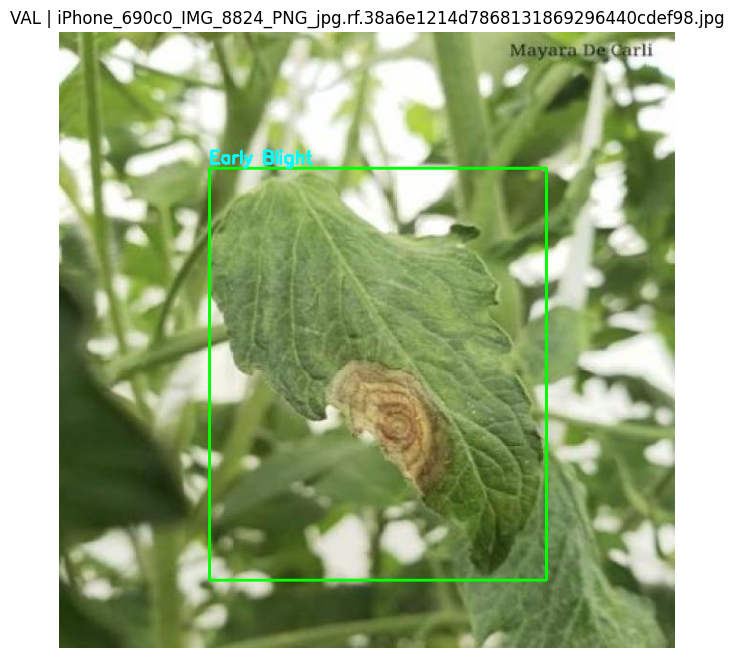

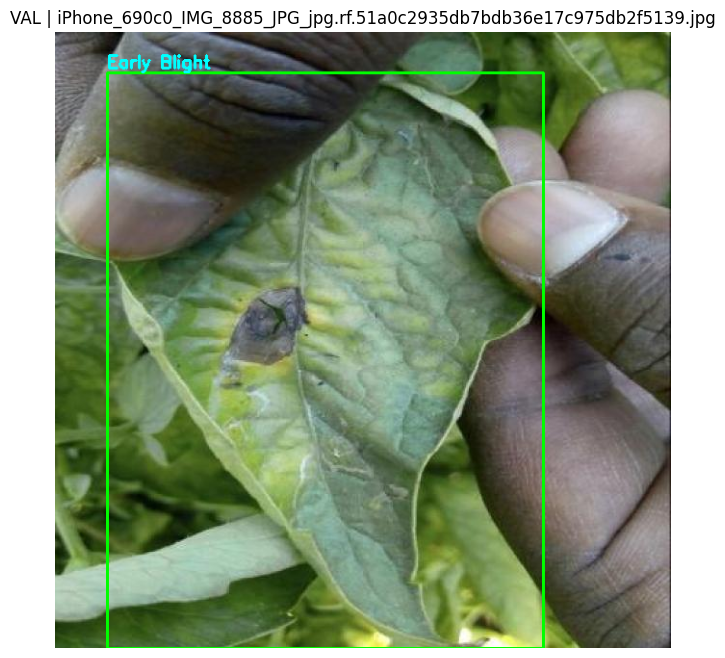

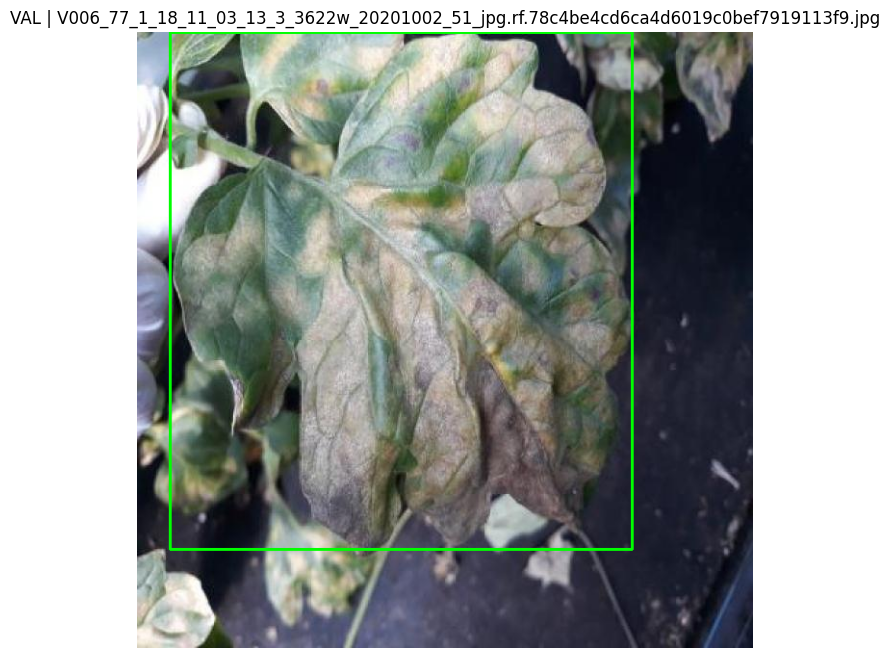

In [9]:
# ------------------------------------------------------------
# 4️⃣ YOLO Dataset Visualization
# ------------------------------------------------------------
def visualize_yolo_split(split_name, num_images=3):
    image_dir = Path(data_config[split_name])
    label_dir = image_dir.parent / "labels"

    img_files = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))
    valid_imgs = [img for img in img_files if (label_dir / f"{img.stem}.txt").exists()]

    if not valid_imgs:
        print(f"⚠️ No labeled images found in {image_dir}")
        return

    random.shuffle(valid_imgs)
    for img_path in valid_imgs[:num_images]:
        label_path = label_dir / f"{img_path.stem}.txt"
        img = cv2.imread(str(img_path))
        h, w = img.shape[:2]

        with open(label_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) < 5: continue
                cls, x, y, bw, bh = map(float, parts[:5])
                cls = int(cls)
                x1, y1 = int((x - bw/2)*w), int((y - bh/2)*h)
                x2, y2 = int((x + bw/2)*w), int((y + bh/2)*h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
                cv2.putText(img, class_names[cls], (x1, y1-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 2)

        plt.figure(figsize=(8,8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"{split_name.upper()} | {img_path.name}")
        plt.show()

visualize_yolo_split("val", num_images=3)

In [10]:
# ------------------------------------------------------------
# 5️⃣ Train YOLOv10n Model
# ------------------------------------------------------------
model = YOLO("yolov10n.pt")

results = model.train(
    data=corrected_yaml,
    epochs=50,
    imgsz=640,
    batch=16,
    project="/kaggle/working/tomato_yolov10_train",
    name="yolov10_tomato",
    device=0,
    workers=2,
    exist_ok=True
)

print("\n✅ Training complete.")
print(f"📂 Best model path: {model.ckpt_path}")

Ultralytics 8.3.223 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov10_tomato, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plo

In [13]:
# ------------------------------------------------------------
# 6️⃣ Evaluate the trained model
# ------------------------------------------------------------

# Load the best model
best_model_path = "/kaggle/working/tomato_yolov10_train/yolov10_tomato/weights/best.pt"
best_model = YOLO(best_model_path)

# Run validation on the test set
metrics = best_model.val(
    data=corrected_yaml,
    split='test',   # evaluate on test set
    imgsz=640,
    batch=16,
    device=0,
    workers=2
)

# Use results_dict to get metrics
results_dict = metrics.results_dict  # correct attribute
precision = results_dict.get('metrics/precision(B)', 0)
recall = results_dict.get('metrics/recall(B)', 0)
mAP50 = results_dict.get('metrics/mAP50(B)', 0)
mAP5095 = results_dict.get('metrics/mAP50-95(B)', 0)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n✅ Evaluation Metrics:")
print(f"mAP@0.5: {mAP50:.4f}")
print(f"mAP@0.5:0.95: {mAP5095:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Ultralytics 8.3.223 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 102 layers, 2,266,923 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1134.3±448.7 MB/s, size: 56.4 KB)
val: Scanning /kaggle/working/tomato_dataset/Tomato leaf diseases dataset for Object Detection/Dataset with augmentation/test/labels.cache... 420 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 420/420 748.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 6.6it/s 4.1s0.2ss
                   all        420       1578      0.975       0.96      0.987       0.95
          Early Blight        135        162      0.987      0.938      0.991      0.963
               Healthy         57        108      0.929      0.889       0.96      0.881
           Late Blight        189        261      0.987      0.996      0.994      0.965
            Leaf Miner     

Displaying training and validation metrics...


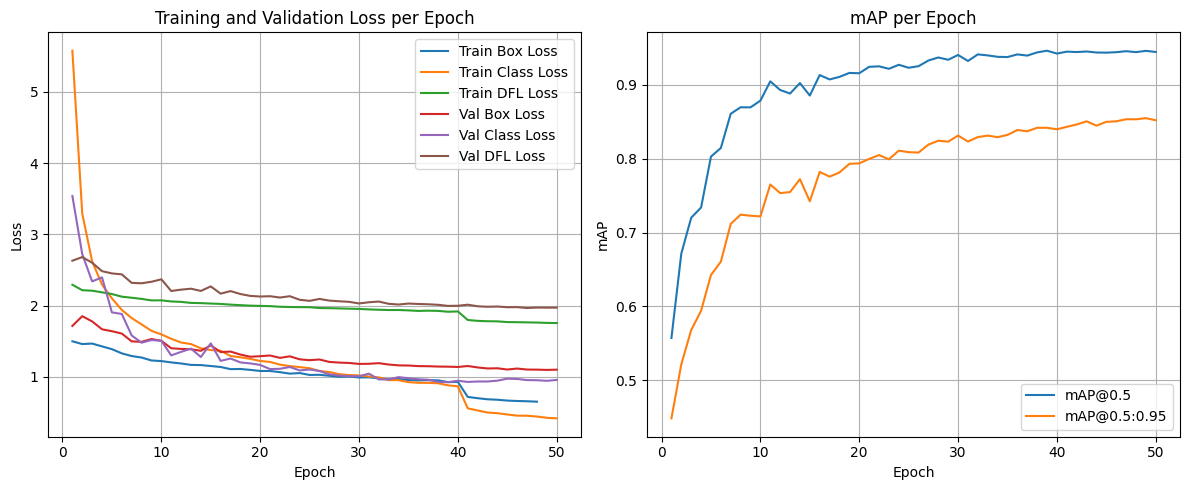


✅ Metric display complete.


In [16]:
import pandas as pd  # <-- add this

# ------------------------------------------------------------
# 7️⃣ Display training and validation metrics
# ------------------------------------------------------------

print("Displaying training and validation metrics...")

# Load the results history
results_path = os.path.join("/kaggle/working/tomato_yolov10_train", "yolov10_tomato", "results.csv")

if os.path.exists(results_path):
    results_df = pd.read_csv(results_path)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss')
    plt.plot(results_df['epoch'], results_df['train/cls_loss'], label='Train Class Loss')
    plt.plot(results_df['epoch'], results_df['train/dfl_loss'], label='Train DFL Loss')
    plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Val Box Loss')
    plt.plot(results_df['epoch'], results_df['val/cls_loss'], label='Val Class Loss')
    plt.plot(results_df['epoch'], results_df['val/dfl_loss'], label='Val DFL Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot mAP
    plt.subplot(1, 2, 2)
    plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP@0.5')
    plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.title('mAP per Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

else:
    print(f"⚠️ Results file not found at {results_path}. Cannot display plots.")

print("\n✅ Metric display complete.")
